# Higgs Boson Challenge: Ridge regression

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Import methods from scripts/
from path import (add_src_to_path, load_json_parameters, DATA_TRAIN_PATH,
                  FIGS_DIR)

# Add src/ to path to import functions
add_src_to_path()

# Import functions from src/
from clean_data import clean_train_test_data_by_jet
from cross_validation import build_poly
from csv_utils import load_csv_data
from helpers import predict_labels
from implementations import ridge_regression
from metrics import accuracy_score, confusion_matrix
from plot_utils import plot_confusion_matrix, plot_accuracies
from print_utils import (get_subset_label, print_shapes, print_shapes_by_jet,
                         print_subset_label)
from split_data import split_by_jet, split_train_test, NB_SUBSETS

In [3]:
# Load data
y, x, ids = load_csv_data(DATA_TRAIN_PATH)
print_shapes(y, x)

Shape of y: (250000,)
Shape of x: (250000, 30)


In [4]:
# Split data train test
x_tr, x_te, y_tr, y_te = split_train_test(y, x)
print('Train:')
print_shapes(y_tr, x_tr)
print('Test:')
print_shapes(y_te, x_te)

Train:
Shape of y: (200000,)
Shape of x: (200000, 30)
Test:
Shape of y: (50000,)
Shape of x: (50000, 30)


In [5]:
# Split train data by jet
y_tr_by_jet, x_tr_by_jet, _ = split_by_jet(y_tr, x_tr)
print_shapes_by_jet(y_tr_by_jet, x_tr_by_jet)

JET = 0:
Shape of y: (79923,)
Shape of x: (79923, 29)
JET = 1:
Shape of y: (61985,)
Shape of x: (61985, 29)
JET >= 2:
Shape of y: (58092,)
Shape of x: (58092, 29)


In [6]:
# Split test data by jet
y_te_by_jet, x_te_by_jet, _ = split_by_jet(y_te, x_te)
print_shapes_by_jet(y_te_by_jet, x_te_by_jet)

JET = 0:
Shape of y: (19990,)
Shape of x: (19990, 29)
JET = 1:
Shape of y: (15559,)
Shape of x: (15559, 29)
JET >= 2:
Shape of y: (14451,)
Shape of x: (14451, 29)


In [7]:
# Clean train and test data by jet
y_tr_by_jet, x_tr_by_jet, y_te_by_jet, x_te_by_jet = clean_train_test_data_by_jet(
    y_tr_by_jet, x_tr_by_jet, y_te_by_jet, x_te_by_jet
)

In [8]:
# Shape of train data
print_shapes_by_jet(y_tr_by_jet, x_tr_by_jet)

JET = 0:
Shape of y: (79923,)
Shape of x: (79923, 18)
JET = 1:
Shape of y: (61985,)
Shape of x: (61985, 22)
JET >= 2:
Shape of y: (58092,)
Shape of x: (58092, 29)


In [9]:
# Shape of test data
print_shapes_by_jet(y_te_by_jet, x_te_by_jet)

JET = 0:
Shape of y: (19990,)
Shape of x: (19990, 18)
JET = 1:
Shape of y: (15559,)
Shape of x: (15559, 22)
JET >= 2:
Shape of y: (14451,)
Shape of x: (14451, 29)


In [10]:
# Load parameters
params = load_json_parameters()
lambda_ = params['ridge_regression']['lambda_']
degrees = params['ridge_regression']['degree']
print('Lambda:', lambda_)
print('Degree by subset:', degrees)

Lambda: 0.001
Degree by subset: [11, 12, 10]


In [11]:
# Run ridge regression
w_by_jet = list()

for i in range(NB_SUBSETS):
    print_subset_label(i)

    # Get train subset
    x_tr_jet, y_tr_jet = x_tr_by_jet[i], y_tr_by_jet[i]

    # Build polynomial basis
    phi_tr_jet = build_poly(x_tr_jet, degrees[i])

    # Run ridge regression
    w, loss = ridge_regression(y_tr_jet, phi_tr_jet, lambda_, verbose=True)

    # Add weights to list
    w_by_jet.append(w)

JET = 0:
Loss: 0.232
JET = 1:
Loss: 0.287
JET >= 2:
Loss: 0.263


In [12]:
# Predict test data by jet
y_pred_by_jet = list()
accuracies = list()
conf_matrices = list()

for i in range(NB_SUBSETS):
    # Get subset
    x_te_jet, y_te_jet, w = x_te_by_jet[i], y_te_by_jet[i], w_by_jet[i]

    # Build polynomial basis
    phi_te_jet = build_poly(x_te_jet, degrees[i])

    # Predict labels
    y_pred = predict_labels(w, phi_te_jet)
    y_pred_by_jet.append(y_pred)

    # Accuracy score
    accuracy = accuracy_score(y_te_jet, y_pred)
    accuracies.append(accuracy)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_te_jet, y_pred)
    conf_matrices.append(conf_matrix)

Accuracy = 0.82498


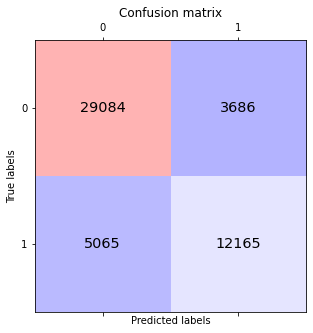

In [13]:
# Concatenate results
y_te = np.concatenate(y_te_by_jet)
y_pred = np.concatenate(y_pred_by_jet)

# Global accuracy
global_accuracy = accuracy_score(y_te, y_pred)
print('Accuracy =', global_accuracy)

# Global confusion matrix
global_conf_matrix = confusion_matrix(y_te, y_pred)
plot_confusion_matrix(global_conf_matrix)

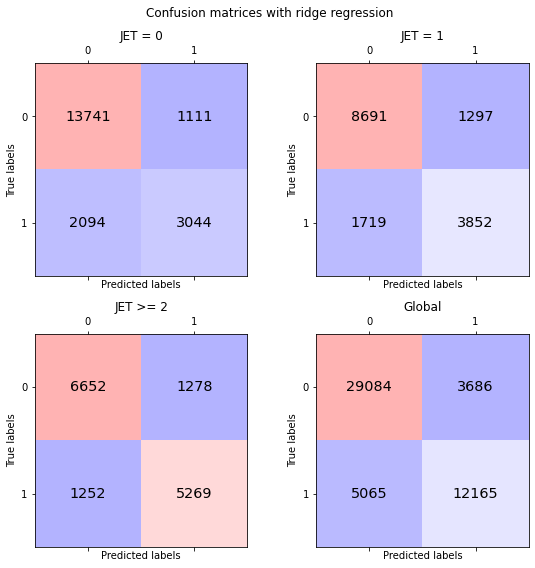

In [14]:
# Plot confusion matrices
plt.figure(figsize=(8, 8))

# Plot subset matrices
for i in range(NB_SUBSETS):
    ax = plt.subplot(2, 2, i + 1)
    plot_confusion_matrix(conf_matrices[i], ax=ax, title=get_subset_label(i))

# Plot global matrix
ax = plt.subplot(2, 2, 4)
plot_confusion_matrix(global_conf_matrix, ax=ax, title='Global')

plt.suptitle('Confusion matrices with ridge regression')
plt.tight_layout()

# Save figure
path = os.path.join(FIGS_DIR, 'confusion_matrix_ridge_regression.pdf')
plt.savefig(path)

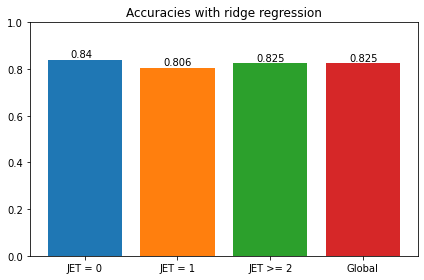

In [15]:
# Plot accuracies
plot_accuracies(accuracies + [global_accuracy],
                title='Accuracies with ridge regression')
plt.tight_layout()

# Save figure
path = os.path.join(FIGS_DIR, 'accuracy_ridge_regression.pdf')
plt.savefig(path)